In [1]:
# Notebook setup

library(repr)
options(repr.plot.width=8, repr.plot.height=6)

Warning message:
“package ‘repr’ was built under R version 3.3.2”

## Linear Regression

_Thanks to Michael Bissell for suggesting this example._

Model:
$$
    y = \beta_0 + \beta_1 x + \epsilon
$$
where $\epsilon \sim N(0, \sigma^2)$.

__Goal: Find the variability in estimates of $\beta$__

In [2]:
# Simulating the model:

b0 = 1
b1 = 5
sigma = 10
n = 10000L

set.seed(37)
x = runif(n)

# SECRET LESSON: Play with the following lines

#epsilon = sigma * rnorm(n)
# But what if it isn't normal?!! GASP!
epsilon = sigma * rt(n, 3)

y = b0 + b1 * x + epsilon

xy = data.frame(x = x, y = y)

If we assume $\epsilon \sim N(0, \sigma^2)$ we can use a t distribution to calculate exact analytic confidence intervals for the coefficients $\beta_0$ and $\beta_1$. That's what R does here:

In [3]:
fit = lm(y ~ x, data = xy)
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


In [28]:
coef(fit)

(Intercept)           x 
  0.9256451   4.5135066

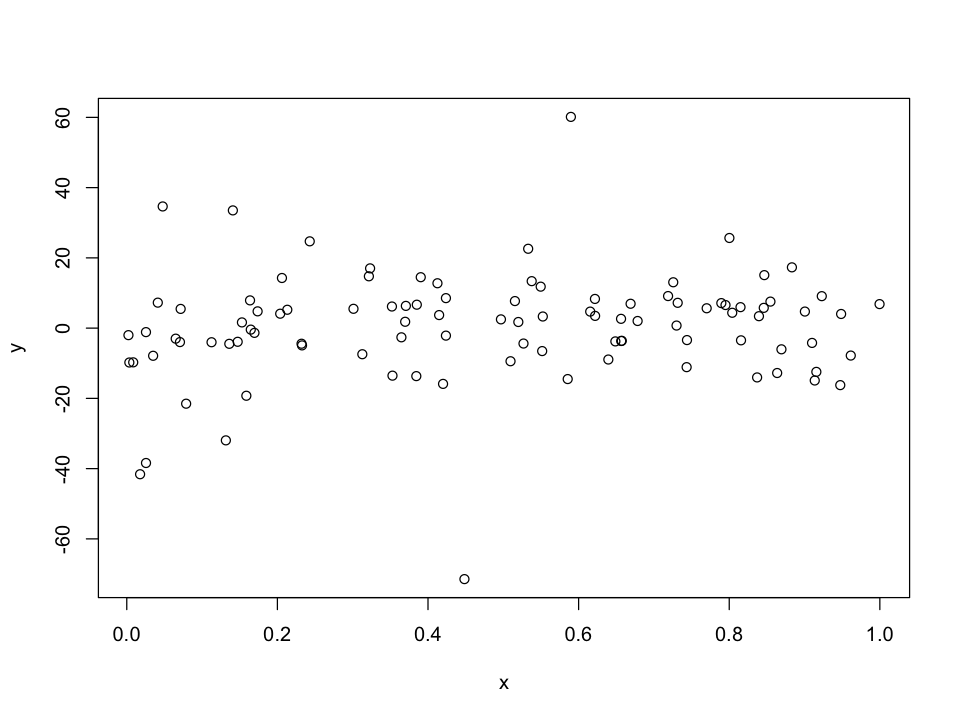

In [4]:
with(xy[1:100, ], plot(x, y))

It's difficult to visually detect the linear relationship because the variance $\sigma^2$ is relatively large.

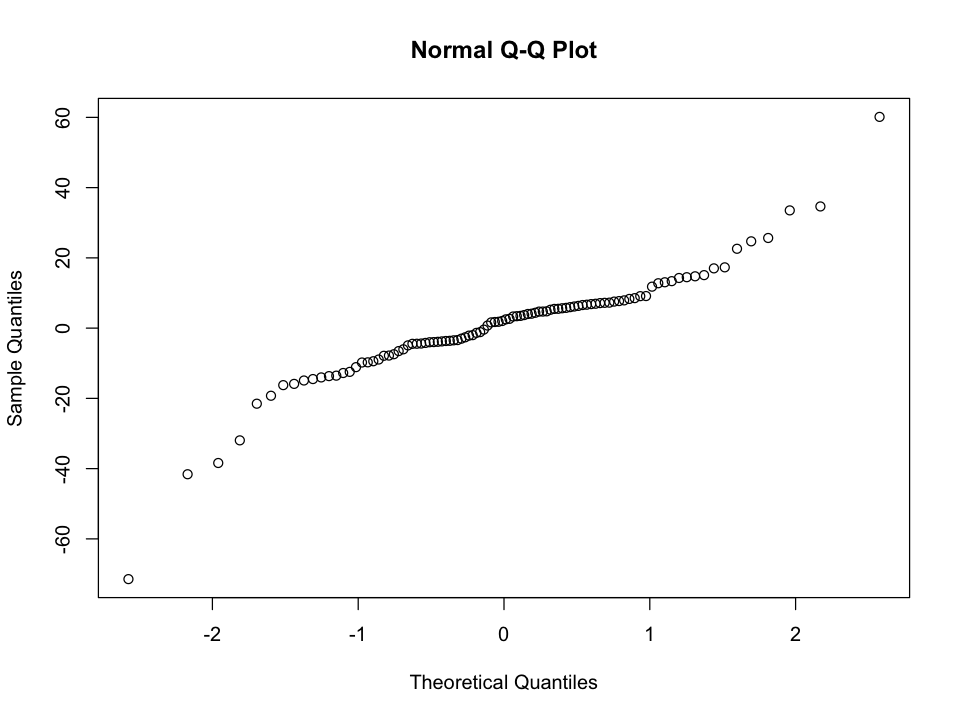

In [5]:
qqnorm(y[1:100])

## Bootstrap

Alternatively, the bootstrap can approximate confidence intervals. The general idea is:
1. Take a sample of size n with replacement of the data
2. Compute the fitted coefficients $\hat{\beta}$.
3. Repeat 1000's of times!

In [6]:
# IMPORTANT: This function takes arguments and does nothing with them.
# And it uses the global variable xy, which MUST be available on the worker machine

# If you think this is weird - you're right!
# We do it here to make something that will easily work in parallel

bootbeta = function(...)
{
    n = nrow(xy)
    xy_boot = xy[sample.int(n, replace = TRUE), ]
    fit_boot = lm(y ~ x, data = xy_boot)
    coef(fit_boot)
}

# Test it!
bootbeta()

(Intercept)           x 
  0.7402433   4.6335976

In [7]:
# We could use replicate()
# doing it this way for consistency with the parallel package
system.time(betas <- lapply(1:1000, bootbeta))

beta_todf = function(betas)
{
    betas = simplify2array(betas)
    row.names(betas) = c("beta0", "beta1")
    betas = data.frame(t(betas)) 
}

betas = beta_todf(betas)

   user  system elapsed 
  7.821   0.032   7.878 

In [8]:
head(betas)

beta0,beta1
1.0345920,3.980326
1.0200276,4.338744
0.6275696,4.863746
0.7279137,4.789514
0.7695179,4.958668
0.3519127,5.788331


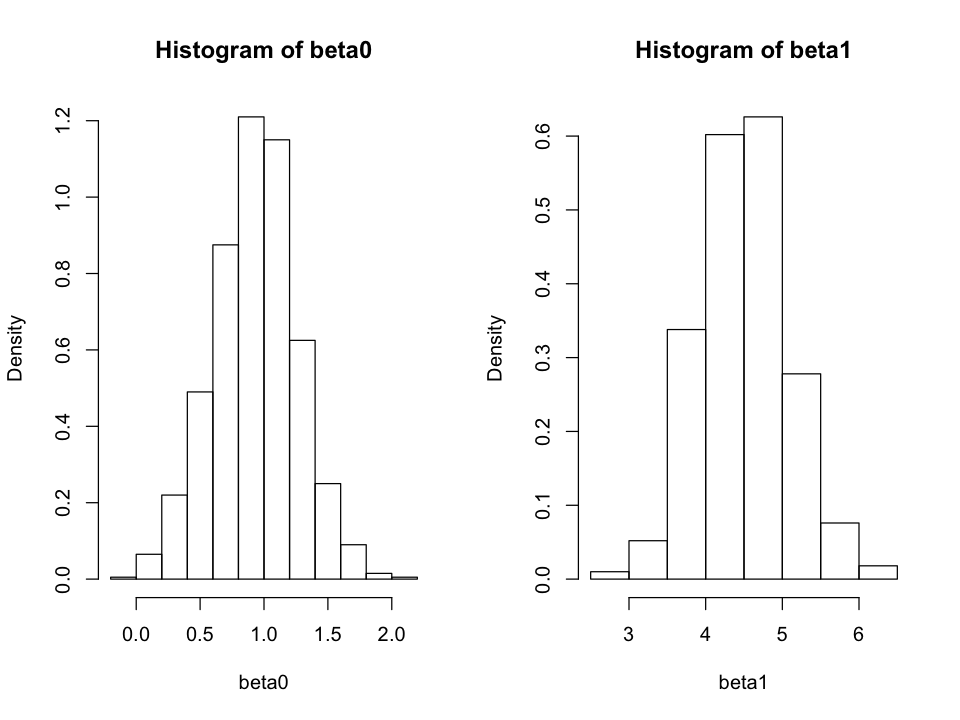

In [9]:
par(mfrow = c(1, 2))
with(betas, hist(beta0, freq = FALSE))
with(betas, hist(beta1, freq = FALSE))

We can take quantiles of the bootstrap statistics to get a 95% confidence interval.

In [10]:
boot_confint = lapply(betas, function(b) quantile(b, probs = c(0.025, 0.975)))
boot_confint

$beta0
     2.5%     97.5% 
0.2608567 1.5561119 

$beta1
    2.5%    97.5% 
3.419527 5.634507

Compare to exact confidence interval for normal from above:

In [11]:
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


# Parallel Time!

What is the embarrassingly parallel problem? Think about it.

Each bootstrap replication can run in parallel.

- takes too long
- bottleneck
- independent

Since the functions in a nice way above, all I needed to do was change `lapply` to `mclapply`.

__Before:__
```
betas <- lapply(1:1000, bootbeta)
```

__After:__
```
betas <- mclapply(1:1000, bootbeta)
```

In [12]:
library(parallel)

detectCores(logical = FALSE)

[1] 4

`detectCores()` is a sanity check. If everything works perfectly then we __may__ see a max speedup of 3.5x for a 4 core machine. This is due to the overhead of setting up parallel workers and collecting the result.

In [13]:
system.time(betas2 <- mclapply(1:1000, bootbeta, mc.cores = 4L))

   user  system elapsed 
  7.904   0.267   2.938 

In [14]:
# Comparing the times, here is our speedup:
7.6 / 2.3

[1] 3.304348

In [15]:
# Sanity check: Look at activity monitor
# Does your fan turn on?
#betas2b <- mclapply(1:9000, bootbeta, mc.cores = 4L)

Now let's look closely at the problem.

Derivation from [Wikipedia](https://en.wikipedia.org/wiki/Simple_linear_regression#Fitting_the_regression_line):
$$
{\displaystyle {\begin{aligned}{\hat {\beta_{1} }}&={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}\\[6pt]&={\frac {\sum _{i=1}^{n}(x_{i}y_{i}-x_{i}{\bar {y}}-{\bar {x}}y_{i}+{\bar {x}}{\bar {y}})}{\sum _{i=1}^{n}(x_{i}^{2}-2x_{i}{\bar {x}}+{\bar {x}}^{2})}}\\[6pt]&={\frac {\sum _{i=1}^{n}(x_{i}y_{i})-{\bar {y}}\sum _{i=1}^{n}x_{i}-{\bar {x}}\sum _{i=1}^{n}y_{i}+n{\bar {x}}{\bar {y}}}{\sum _{i=1}^{n}(x_{i}^{2})-2{\bar {x}}\sum _{i=1}^{n}x_{i}+n{\bar {x}}^{2}}}\\[6pt]&={\frac {{\frac {1}{n}}\sum _{i=1}^{n}x_{i}y_{i}-{\bar {x}}{\bar {y}}}{{\frac {1}{n}}\sum _{i=1}^{n}{x_{i}^{2}}-{\overline {x}}^{2}}}\\[6pt]&={\frac {{\overline {xy}}-{\bar {x}}{\bar {y}}}{{\overline {x^{2}}}-{\bar {x}}^{2}}}={\frac {\operatorname {Cov} [x,y]}{\operatorname {Var} [x]}}\\&=r_{xy}{\frac {s_{y}}{s_{x}}},\\[6pt]{\hat {\beta_{0} }}&={\bar {y}}-{\hat {\beta_{1} }}\,{\bar {x}},\end{aligned}}}
$$

This can be expressed in terms of the sums of squares and products of `x` and `y`. Since we only need the coefficients we may be able to compute this slightly faster than R's `lm()`.

In [32]:
bootbeta_fastR = function(...)
{
xy_boot = xy[sample.int(n, replace = TRUE), ]
x = xy_boot$x
y = xy_boot$y
xbar = mean(x)
ybar = mean(y)
x2bar = mean(x*x)
xybar = mean(x*y)
beta = numeric(2)
beta[2] = (xybar - xbar * ybar) / (x2bar - xbar * xbar)
beta[1] = ybar - beta[2] * xbar
beta
}

bootbeta_fastR()

[1] 0.4142567 5.1834867

In [34]:
system.time(betas2c <- mclapply(1:1000, bootbeta_fastR, mc.cores = 4L))

   user  system elapsed 
  5.917   0.136   1.589 

In [37]:
head(betas2c)

[[1]]
[1] 1.383431 3.854664

[[2]]
[1] 1.081159 4.881829

[[3]]
[1] 0.8885351 4.8453438

[[4]]
[1] 1.233401 3.758356

[[5]]
[1] 1.000592 4.396677

[[6]]
[1] 0.9026243 4.7330710

![](Faster-MEME.jpg)

We do this to accelerate our code. So let's take it a step further and write it in C.

Who has programmed in R / C?

This can be a big jump, especially when starting out. I used to think C was an old language, or too low level so I didn't need to know it. But then I became interested in parallel programming and GPUs (graphical processing units)- C is very much alive. If you hope to really understand R it helps to learn C.

Here's the C code: https://github.com/clarkfitzg/junkyard/blob/master/iidata/parallelR/bootbetas.c#L8

In [16]:
# Compile the C code into a shared library
# Better to do this from the shell to check for errors
#system("R CMD SHLIB bootbetas.c")

# Load into R
dyn.load("bootbetas.so")

In [17]:
out = .C("fit_ols", x, y, n, beta = numeric(2))$beta

In [18]:
# Sanity check: This should be numerically 0
out - coef(fit)

(Intercept)             x 
 2.997602e-15 -2.753353e-14

In [19]:
# An example of R wrapping C code

bootstrap_c = function(x, y, nboots = 1000L)
{
    n = as.integer(length(x))
    if(n > 32767) stop("That might not work with rand() in C")
    nboots = as.integer(nboots)
    beta = .C("bootstrap"
       , as.numeric(x)
       , as.numeric(y)
       , n
       , nboots
       , beta = numeric(2L * nboots)
      )$beta
    matrix(beta, nrow = 2)
}
    
system.time(betas3 <- bootstrap_c(x, y))

   user  system elapsed 
  0.085   0.000   0.085 

In [20]:
betas3[, 1:10]

1.149893,0.9177506,0.7856358,1.473788,0.2429629,0.8952444,1.168899,1.203681,1.353748,1.121525
3.905455,4.5157709,4.8685547,3.925990,5.9441370,4.3028448,4.589751,3.986058,3.451535,3.966871


In [21]:
# Are these reasonable?
boot_confint

$beta0
     2.5%     97.5% 
0.2608567 1.5561119 

$beta1
    2.5%    97.5% 
3.419527 5.634507

This ran in 86 ms compared to 7.6 seconds for the equivalent R code. That's two orders of magnitude faster!

## Why?

R's `lm()` is passed to `lm.fit()` which calls a QR decomposition written in C:
```
.Call(C_Cdqrls, x, y, tol, FALSE)
```

The R version is general and robust. This means if you pass it something strange, say with a bunch of NA's, R will gracefully handle it. The C version on the other hand...

In [22]:
# A very different implementation in C:

bootstrap_c2 = function(x, y, nboots = 1000L)
{
    n = as.integer(length(x))
    if(n > 32767) stop("That might not work with rand() in C")
    nboots = as.integer(nboots)
    beta = .C("bootstrap2"
       , as.numeric(x)
       , as.numeric(y)
       , n
       , nboots
       , beta = numeric(2L * nboots)
      )$beta
    matrix(beta, nrow = 2)
}
    
system.time(betas4 <- bootstrap_c2(x, y))

   user  system elapsed 
  0.091   0.000   0.091 

In [23]:
betas4[, 1:10]

0.4895086,1.195943,0.6587167,1.256587,1.291064,1.050415,0.7144871,0.9764939,0.7086483,1.060944
5.0364153,4.345410,4.9774574,3.352929,3.874136,4.325879,4.5698844,4.1754827,4.7301859,4.121760


## 86 ms? We can do better!

![](Faster-MEME.jpg)

The sum of squares in the C code can be parallelized across bootstrap samples as well. So do it with thousands of threads simultaneously on a GPU (graphical processing unit) using OpenCL (a variant of C). OpenMP is somewhat similar.

https://github.com/clarkfitzg/phd_research/blob/master/gpu/bootbeta.cl#L13

The GPU version can do this same problem in __~8 ms__. Another order of magnitude improvement.

_I totally cheated here and used the Julia language rather than R, because I happened to have code handy that makes it easy to write a kernel._

This problem is ideal for a GPU because:
- It has 1000+ parallel units
- It does many computations on the same data

Conversely, if a problem doesn't exhibit those two characteristics, then using a GPU likely won't help. 

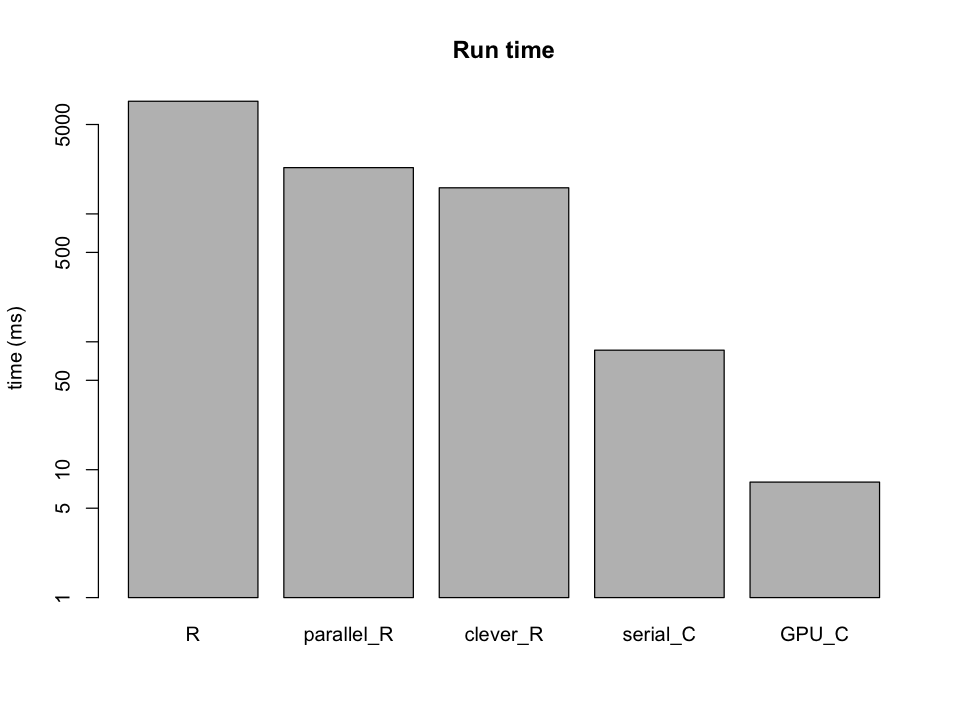

In [40]:
times = c(R = 7600, parallel_R = 2300, clever_R = 1600, serial_C = 86, GPU_C = 8)
barplot(times, log = "y", ylab = "time (ms)", main = "Run time", ylim = c(1, 8000))

# Conclusion:

The graph shows what kind of speedup is possible when we combine R with parallelism and C. More programming effort rewards us with more speed.

- R's `mclapply()` is a wonderful way for easy parallelization
- With some effort, C can often lead to speedups
- GPUs take parallelism to another level

# Thanks! Questions?

![](puppies.jpg)

Fun with programming on Twitter: [@clarkfitzg](https://twitter.com/clarkfitzg)

This presentation: https://goo.gl/glao6J

Follow ups: Find me in the DSI in the library.

Good luck- you're going to need it :)

## References:

- [The Art of R Programming](https://www.amazon.com/Art-Programming-Statistical-Software-Design/dp/1593273843) by Norm Matloff. Section on parallel programming is brief but essential knowledge.
- R’s [parallel package vignette](https://stat.ethz.ch/R-manual/R-devel/library/parallel/doc/parallel.pdf). Very useful for understanding the parallel package.
- CRAN Task View:  [High-Performance and Parallel Computing with R](https://cran.r-project.org/web/views/HighPerformanceComputing.html). Shows all the wild and wonderful packages to accelerate R.
- [Writing R Extensions](https://cran.r-project.org/doc/manuals/r-release/R-exts.html). Definitive guide for using C with R.
- [Parallel guide](https://wrathematics.github.io/RparallelGuide/) from @wrathmatics. An explicit and hilarious guide to 